### Import
<hr style="border:2px solid magenta">  

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend

from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives

from src.extract_to_df import extract_to_df
from src.visualizations import plot_graph
from src.metric_notes import metric_note

#prevent a bug that some images are truncated
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


### Data Extraction

<hr style="border:2px solid magenta">  

In [4]:
test = Path('Data/test')
train = Path('Data/train')
valid = Path('Data/valid')

train_df = extract_to_df(train, 'Train')
test_df = extract_to_df(test, 'Test')
val_df = extract_to_df(valid,'Valid')

train_generator = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_generator = ImageDataGenerator(
    rescale=1./255
)

pixel = 64
size = f'{pixel}x{pixel}'

train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                   x_col='Path',
                                                   y_col='Label',
                                                   target_size=(pixel, pixel),
                                                   class_mode='binary',
                                                   color_mode='rgb',
                                                   shuffle=True,
                                                   seed=42,
                                                   batch_size=128)

valid_images = train_generator.flow_from_dataframe(dataframe=val_df,
                                                   x_col='Path',
                                                   y_col='Label',
                                                   target_size=(pixel, pixel),
                                                   class_mode='binary',
                                                   color_mode='rgb',
                                                   shuffle=True,
                                                   seed=42,
                                                   batch_size=64)

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='Path',
                                                 y_col='Label',
                                                 target_size=(pixel, pixel),
                                                 class_mode='binary',
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 seed=42,
                                                 batch_size=128)


In [9]:
metrics = metric_note(train_images, test_images, valid_images)


<hr style="border:2px solid magenta">  

Create a function that we can tweak the hyperparameters of the model

In [11]:
def create_cnn1(learning_rate, hidden_units = 32, dropout = 0.1):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    cnn1 = Sequential()
    cnn1.add(Conv2D(filters=hidden_units,
                kernel_size=(3, 3),
                activation='relu',
                input_shape=(pixel, pixel, 3)))
    cnn1.add(MaxPooling2D(pool_size=(2, 2)))
    cnn1.add(Dropout(dropout))

    cnn1.add(Flatten())

    cnn1.add(Dense(hidden_units*2, activation='relu'))
    cnn1.add(Dense(1, activation='sigmoid'))
    
    cnn1.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy', 
                      TruePositives(thresholds=.5), 
                      TrueNegatives(thresholds=.5), 
                      FalsePositives(thresholds=.5), 
                      FalseNegatives(thresholds=.5)])
    
    return cnn1

Adding an early stop to stop the model from overfitting

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=4,
            restore_best_weights=True
        )

Created a nested for loop that could go through the hyperparameters. Decided that fiddling with the learning rate, nodes, and dropout will be important in the improving the model. Using the validation images as the scoring. If the model performs well with the validation, it will tend to do well with the test images from my previous iterations. 

In [14]:
learning_rates = [0.001, 0.005]
nodes = [32,64,128]
dropouts = [0.01, 0.05, 0.1, 0.2]
best_metric,best_learning = 0,0

for learning_rate in learning_rates:
    for node in nodes:
        for dropout in dropouts:
            model = create_cnn1(learning_rate=learning_rate, hidden_units = node, dropout = dropout)
            model.fit(train_images,
                            batch_size = 64, 
                            epochs = 25,
                            callbacks = [early_stop])

            #look at accuracy
            valid_metric = model.evaluate(valid_images)[1]

            if valid_metric > best_metric:
                best_metric = valid_metric
                best_learning = learning_rate
                best_dropout = dropout
                best_node = node

print(best_metric)
print(best_learning)

Epoch 1/25
237/237 [==============================] - 62s 257ms/step - loss: 0.2840 - accuracy: 0.8815 - true_positives_2: 14187.0000 - true_negatives_2: 12478.0000 - false_positives_2: 2022.0000 - false_negatives_2: 1563.0000
Epoch 2/25
237/237 [==============================] - 61s 255ms/step - loss: 0.2152 - accuracy: 0.9138 - true_positives_2: 14850.0000 - true_negatives_2: 12792.0000 - false_positives_2: 1708.0000 - false_negatives_2: 900.0000
Epoch 3/25
237/237 [==============================] - 61s 256ms/step - loss: 0.2029 - accuracy: 0.9173 - true_positives_2: 14872.0000 - true_negatives_2: 12877.0000 - false_positives_2: 1623.0000 - false_negatives_2: 878.0000
Epoch 4/25
237/237 [==============================] - 61s 258ms/step - loss: 0.1950 - accuracy: 0.9210 - true_positives_2: 14940.0000 - true_negatives_2: 12920.0000 - false_positives_2: 1580.0000 - false_negatives_2: 810.0000
Epoch 5/25
237/237 [==============================] - 60s 254ms/step - loss: 0.1852 - accuracy:

In [15]:
print(best_learning, best_dropout, best_node)

0.001 0.2 128


The learning was 0.001 which was something I expected. The dropout was 0.2 which is lower than I thought. I thought around 0.3 would be good in improving the model but this function proved otherwise. The best node was 128 which is almost triple what I had originally of 32 nodes. 

In [16]:
model1 = create_cnn1(best_learning, best_node, best_dropout)
model1.fit(train_images,
              batch_size=64,
              epochs=25,
              callbacks=[early_stop])

Epoch 1/25
237/237 [==============================] - 64s 266ms/step - loss: 0.4004 - accuracy: 0.8603 - true_positives_26: 13727.0000 - true_negatives_26: 12297.0000 - false_positives_26: 2203.0000 - false_negatives_26: 2023.0000
Epoch 2/25
237/237 [==============================] - 60s 254ms/step - loss: 0.2146 - accuracy: 0.9165 - true_positives_26: 14691.0000 - true_negatives_26: 13032.0000 - false_positives_26: 1468.0000 - false_negatives_26: 1059.0000
Epoch 3/25
237/237 [==============================] - 60s 254ms/step - loss: 0.2007 - accuracy: 0.9220 - true_positives_26: 14734.0000 - true_negatives_26: 13157.0000 - false_positives_26: 1343.0000 - false_negatives_26: 1016.0000
Epoch 4/25
237/237 [==============================] - 60s 255ms/step - loss: 0.1872 - accuracy: 0.9259 - true_positives_26: 14791.0000 - true_negatives_26: 13218.0000 - false_positives_26: 1282.0000 - false_negatives_26: 959.0000
Epoch 5/25
237/237 [==============================] - 61s 255ms/step - loss: 

Creating the model with these hyperparameter and evaluate them to see the confusion matrix.

99/99 [==============================] - 13s 130ms/step - loss: 0.1467 - accuracy: 0.9441 - true_positives_26: 3242.0000 - true_negatives_26: 2706.0000 - false_positives_26: 114.0000 - false_negatives_26: 238.0000


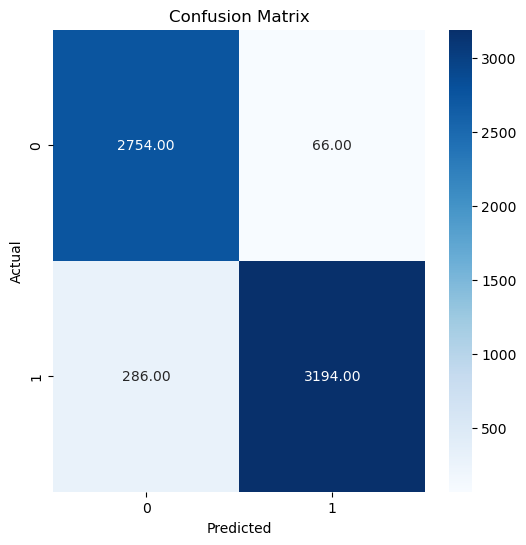

In [17]:
metrics.evaluate(model1, 'CNN1c', size)

This performed slightly worse than the base CNN4 model that I made earlier. This has more false negatives which is worrisome as the model would predict an image as no wildfire when there is a wildfire. The goal of this model is to reduce that so we can catch wildfire before they can get too big. 

In [18]:
metrics.printout.to_csv(f'Dataframes/{size}Tuned_CNN.csv')